This notebook covers the implementation of **bisection method** with basic diagnostics

> Note: The bisection algorithm is a classic root-finding routine; the implementation below follows the standard textbook description (see e.g. the bisection method reference on Wikipedia for background).


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

np.set_printoptions(precision=6, suppress=True)


## 1) Bisection method (root finding)

**Goal:** find an `x` such that `g(x)=0` on an interval `[left, right]`.

Bisection works when:
1. `g` is continuous on `[left, right]`, and
2. the endpoints have **opposite signs**: `g(left) * g(right) < 0`.

Algorithm:
At each step we:
- take the midpoint
- keep the half-interval that still brackets a sign change

This halves the interval length every iteration, giving predictable convergence.


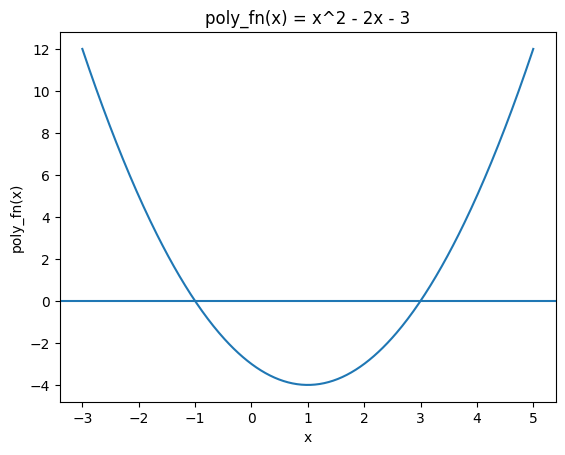

In [3]:
# Example function (a simple polynomial)
def poly_fn(x: np.ndarray ) -> np.ndarray :
    return x**2 - 2*x - 3

# Quick visualization to locate sign changes
grid = np.linspace(-3.0, 5.0, 400)
plt.figure()
plt.axhline(0)
plt.plot(grid, poly_fn(grid))
plt.title("poly_fn(x) = x^2 - 2x - 3")
plt.xlabel("x")
plt.ylabel("poly_fn(x)")
plt.show()


### Implementation

The function below returns both the root estimate and a small history object
(for debugging and plotting convergence).


In [5]:
@dataclass
class BisectionResult:
    root: float
    iterations: int
    bracket: tuple[float, float]
    f_at_root: float
    midpoints: np.ndarray
    residuals: np.ndarray

def bisect_root(
    func,
    left: float,
    right: float,
    *,
    tolerance: float = 1e-10,
    max_steps: int = 200
) -> BisectionResult:
    """Approximate a root of `func` in [left, right] via bisection.

    Parameters
    ----------
    func : callable
        Continuous function.
    left, right : float
        Initial interval endpoints.
    tolerance : float
        Stop when interval width <= tolerance or |f(mid)| <= tolerance.
    max_steps : int
        Maximum number of iterations.

    Returns
    -------
    BisectionResult
        Root estimate + diagnostics.

    Raises
    ------
    ValueError
        If the initial bracket does not contain a sign change.
    """
    f_left = float(func(left))
    f_right = float(func(right))

    if np.sign(f_left) == 0:
        return BisectionResult(left, 0, (left, right), f_left, np.array([left]), np.array([abs(f_left)]))
    if np.sign(f_right) == 0:
        return BisectionResult(right, 0, (left, right), f_right, np.array([right]), np.array([abs(f_right)]))

    if f_left * f_right > 0:
        raise ValueError(
            "Bisection requires a sign change: func(left) and func(right) must have opposite signs."
        )

    mids, resids = [], []
    a, b = float(left), float(right)

    for k in range(1, max_steps + 1):
        mid = 0.5 * (a + b)
        f_mid = float(func(mid))

        mids.append(mid)
        resids.append(abs(f_mid))

        # Stopping conditions
        if abs(f_mid) <= tolerance or (b - a) <= tolerance:
            return BisectionResult(
                root=mid,
                iterations=k,
                bracket=(a, b),
                f_at_root=f_mid,
                midpoints=np.array(mids, dtype=float),
                residuals=np.array(resids, dtype=float),
            )

        # Keep the sub-interval that preserves the sign change
        if f_left * f_mid < 0:
            b = mid
            f_right = f_mid
        else:
            a = mid
            f_left = f_mid

    # If we hit max_steps, return the best midpoint we have
    mid = 0.5 * (a + b)
    f_mid = float(func(mid))
    mids.append(mid)
    resids.append(abs(f_mid))
    return BisectionResult(
        root=mid,
        iterations=max_steps,
        bracket=(a, b),
        f_at_root=f_mid,
        midpoints=np.array(mids, dtype=float),
        residuals=np.array(resids, dtype=float),
    )


### Finding both roots

From the plot, the curve crosses zero twice. We'll bracket each root and run bisection.


In [6]:
root_left = bisect_root(poly_fn, left=-2.0, right=1.0)
root_right = bisect_root(poly_fn, left=1.0, right=5.0)

root_left, root_right


(BisectionResult(root=-1.000000000014552, iterations=36, bracket=(-1.0000000000582077, -0.9999999999708962), f_at_root=5.820766091346741e-11, midpoints=array([-0.5     , -1.25    , -0.875   , -1.0625  , -0.96875 , -1.015625,
        -0.992188, -1.003906, -0.998047, -1.000977, -0.999512, -1.000244,
        -0.999878, -1.000061, -0.999969, -1.000015, -0.999992, -1.000004,
        -0.999998, -1.000001, -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ,
        -1.      , -1.      , -1.      , -1.      , -1.      , -1.      ]), residuals=array([1.75    , 1.0625  , 0.484375, 0.253906, 0.124023, 0.062744,
        0.031189, 0.01564 , 0.007809, 0.003907, 0.001953, 0.000977,
        0.000488, 0.000244, 0.000122, 0.000061, 0.000031, 0.000015,
        0.000008, 0.000004, 0.000002, 0.000001, 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.      , 0.      ,
        0.      , 0.      , 0.      , 0.      , 0.    

In [7]:
print(f"Left root estimate:  {root_left.root:.12f}   |poly_fn(root)| = {abs(root_left.f_at_root):.3e}")
print(f"Right root estimate: {root_right.root:.12f}   |poly_fn(root)| = {abs(root_right.f_at_root):.3e}")


Left root estimate:  -1.000000000015   |poly_fn(root)| = 5.821e-11
Right root estimate: 3.000000000000   |poly_fn(root)| = 0.000e+00


### Convergence sketch

A quick diagnostic is to look at the residual `|g(mid_k)|` across iterations.
Because the interval shrinks by a factor of two each step, the residual typically drops steadily (though not always perfectly monotonically).


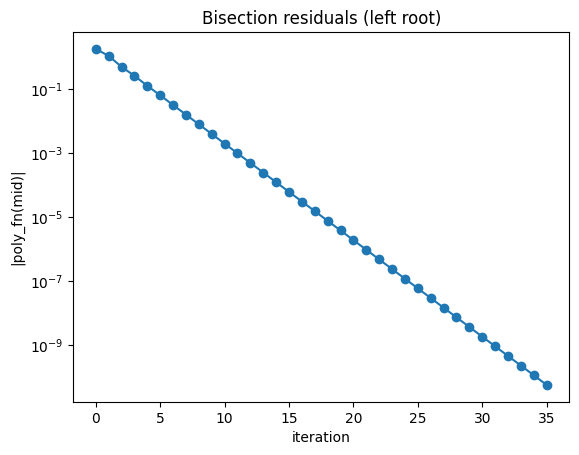

In [9]:
plt.figure()
plt.semilogy(root_left.residuals, marker="o")
plt.title("Bisection residuals (left root)")
plt.xlabel("iteration")
plt.ylabel("|poly_fn(mid)|")
plt.show()


## 2) NumPy linear algebra: shapes that matter

NumPy behaves differently depending on whether you use:
- a **1D array** with shape `(n,)`, or
- a **column vector** with shape `(n, 1)`, or
- a **row vector** with shape `(1, n)`.

For reliable linear algebra, I prefer being explicit with 2D arrays (matrices/column vectors).


In [10]:
mat_A = np.array([[1, 2],
                  [3, 4],
                  [5, 6]])           # shape (3, 2)

mat_B = np.array([[1, 2, 3],
                  [4, 5, 6]])         # shape (2, 3)

print("mat_A.shape =", mat_A.shape)
print("mat_B.shape =", mat_B.shape)
print("mat_A @ mat_B has shape:", (mat_A @ mat_B).shape)


mat_A.shape = (3, 2)
mat_B.shape = (2, 3)
mat_A @ mat_B has shape: (3, 3)


If matrix dimensions do not align, NumPy raises an error.  
Below is an intentional mismatch to show the message you typically get when debugging.


In [11]:
mat_C = np.array([[1, 2],
                  [3, 4]])            # shape (2, 2)

try:
    bad = mat_A @ mat_C  # (3,2) @ (2,2) is OK; let's force a mismatch instead
    bad = mat_C @ mat_A  # (2,2) @ (3,2) fails: inner dims 2 vs 3
except ValueError as err:
    print("Expected error:")
    print(err)


Expected error:
matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 3 is different from 2)


### 1D vectors vs 2D vectors

A 1D array has no “row” or “column” orientation, so transposes can look like they work while silently doing something else.


In [12]:
row_vec = np.array([[1, 2, 3]])   # shape (1, 3)
col_vec = row_vec.T                # shape (3, 1)
flat_vec = np.array([1, 2, 3])     # shape (3,)

print("row_vec.shape =", row_vec.shape)
print("col_vec.shape =", col_vec.shape)
print("flat_vec.shape =", flat_vec.shape)

print("\nOuter product using explicit 2D vectors (3x1 @ 1x3):")
print(col_vec @ row_vec)

print("\nDot with 1D arrays (inner product):")
print(flat_vec.T @ flat_vec)


row_vec.shape = (1, 3)
col_vec.shape = (3, 1)
flat_vec.shape = (3,)

Outer product using explicit 2D vectors (3x1 @ 1x3):
[[1 2 3]
 [2 4 6]
 [3 6 9]]

Dot with 1D arrays (inner product):
14


### Four similar-looking operations, four different outcomes

These examples are small, but they capture a lot of real-world debugging pain.


In [13]:
x_flat = np.array([1, 2, 3])
y_flat = np.array([4, 5, 6])

x_row = np.array([[1, 2, 3]])
y_row = np.array([[4, 5, 6]])

x_col = x_row.T

print("1) 1D dot 1D (inner product):", x_flat @ y_flat)
print("2) row * row (elementwise):\n", x_row * y_row)
print("3) col @ row (outer product):\n", x_col @ y_row)

try:
    print("4) row @ row (invalid):", x_row @ y_row)
except ValueError as err:
    print("4) Expected error:", err)


1) 1D dot 1D (inner product): 32
2) row * row (elementwise):
 [[ 4 10 18]]
3) col @ row (outer product):
 [[ 4  5  6]
 [ 8 10 12]
 [12 15 18]]
4) Expected error: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 3)


## 3) Translating a matrix expression into NumPy

We will compute:


$C = \log \det\Big(B^\top v v^\top B + (B^\top B) \odot (B^\top B)\Big)$

Where:
- $(B\in\mathbb{R}^{3\times 2})$ is the matrix $\begin{pmatrix}1&2\\3&4\\5&6\end{pmatrix}$
- $v\in\mathbb{R}^{3}$ is the all-ones vector
- $\odot$ is the elementwise (Hadamard) product

Implementation details:
- I use `np.linalg.slogdet` instead of `np.log(np.linalg.det(.))` to be more numerically stable.


In [18]:
def compute_C(B_mat: np.ndarray, ones: np.ndarray) -> float:
    """Compute C = log det(B^T v v^T B + (B^T B) ⊙ (B^T B)).

    B_mat must be (m, n) and ones must be (m, 1).
    """
    B_mat = np.asarray(B_mat, dtype=float)
    ones = np.asarray(ones, dtype=float)

    if B_mat.ndim != 2:
        raise ValueError("B_mat must be 2D.")
    if ones.ndim != 2 or ones.shape[1] != 1:
        raise ValueError("ones must be a column vector with shape (m, 1).")
    if ones.shape[0] != B_mat.shape[0]:
        raise ValueError("ones and B_mat must have the same number of rows.")

    # term1 = B^T v v^T B
    term1 = B_mat.T @ (ones @ ones.T) @ B_mat

    # term2 = (B^T B) ⊙ (B^T B)
    gram = B_mat.T @ B_mat
    term2 = gram * gram

    core = term1 + term2

    sign, logabsdet = np.linalg.slogdet(core)
    if sign <= 0:
        raise ValueError("Matrix inside log(det(.)) must have positive determinant.")
    return float(logabsdet)

B_demo = np.array([[1, 2],
                   [3, 4],
                   [5, 6]], dtype=float)

v_ones = np.ones((3, 1), dtype=float)

C_value = compute_C(B_demo, v_ones)
C_value


11.568776357710231